# Data Processing #

In [31]:
import pandas as pd

# Read the dataset.
dtypes = {
    'airline': str,
    'source_city': str,
    'departure_time': str,
    'stops': str,
    'destination_city': str,
    'class': str,
    'duration': float,
    'days_left': int,
    'price': int
}
df = pd.read_csv('Clean_Dataset.csv', dtype=dtypes)

# Reformat the dataset.
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('source_city', axis=1, inplace=True)
df.drop('destination_city', axis=1, inplace=True)

# One hot encoding.
df = pd.get_dummies(df, columns=['class'], drop_first=True)
df = pd.get_dummies(df, columns=['airline', 'stops'], drop_first=False)
df = df.astype({col: 'int' for col in df.select_dtypes('bool').columns})

# Label encoding.
times_map = {'Early_Morning': 1, 'Morning': 2, 'Afternoon': 3, 'Evening': 4, 'Night': 5, 'Late_Night': 6}
flights_map = {value: index for index, value in enumerate(df['flight'].unique())} 
df = df.replace({'departure_time': times_map})
df = df.replace({'arrival_time': times_map})
df = df.replace({'flight': flights_map})

# Reorder columns.
df.sort_values(['price', 'days_left'], inplace=True, ascending=[False, True])
columns = ['class_Economy'] + [col for col in df.columns if col != 'class_Economy']
df = df[columns]

print('Size:', df.shape)
df.head()


/var/folders/7_/4zrcj6qx27v_06ygdmm8d7580000gn/T/ipykernel_65344/658479642.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'departure_time': times_map})
/var/folders/7_/4zrcj6qx27v_06ygdmm8d7580000gn/T/ipykernel_65344/658479642.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'arrival_time': times_map})


Size: (300153, 16)


/var/folders/7_/4zrcj6qx27v_06ygdmm8d7580000gn/T/ipykernel_65344/658479642.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'flight': flights_map})


,class_Economy,flight,departure_time,arrival_time,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,stops_one,stops_two_or_more,stops_zero
261377,0,1079,2,5,13.50,3,123071,0,0,0,0,0,1,1,0,0
216096,0,169,1,4,10.92,5,117307,0,0,0,0,0,1,0,1,0
215859,0,59,4,4,21.08,1,116562,0,0,0,0,0,1,0,1,0
277345,0,1261,5,3,16.42,3,115211,0,0,0,0,0,1,1,0,0
270999,0,1079,2,4,9.50,17,114705,0,0,0,0,0,1,1,0,0


# Data Loader #

In [32]:
# Custom Data Loader
import torch
from torch.utils.data import Dataset, DataLoader

class FlightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [33]:
from sklearn.model_selection import train_test_split

# Get the features and target.
X = df.drop('price', axis=1).values
y = df['price'].values

# Split the dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Datasets.
train_dataset = FlightDataset(X_train, y_train)
val_dataset = FlightDataset(X_val, y_val)
test_dataset = FlightDataset(X_test, y_test)

# Data Loaders.
BATCH = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH)
test_loader = DataLoader(test_dataset, batch_size=BATCH)


# Model Training #

In [34]:
# Simple MLP class
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [35]:
# Hyperparameters
INPUT_SIZE = X_train.shape[1]
HIDDEN_SIZE = 256
OUTPUT_SIZE = 1
LR = 0.002
WD = 0.00001
EPOCHS = 500

print('Input size:', INPUT_SIZE)

Input size: 15


In [36]:
# Train
import torch.optim as optim

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
losses = {'train': [], 'val': []}

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    losses['train'].append(train_loss/len(train_loader))

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            val_loss += criterion(y_pred, y_batch.view(-1, 1)).item()
        losses['val'].append(val_loss/len(val_loader))
        if (epoch+1) % 10 == 0:
            print(f'Epoch: {epoch+1}/{EPOCHS}, Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')

Epoch: 10/500, Loss: 3376.665853953282, Val Loss: 3374.115131498133


KeyboardInterrupt: 

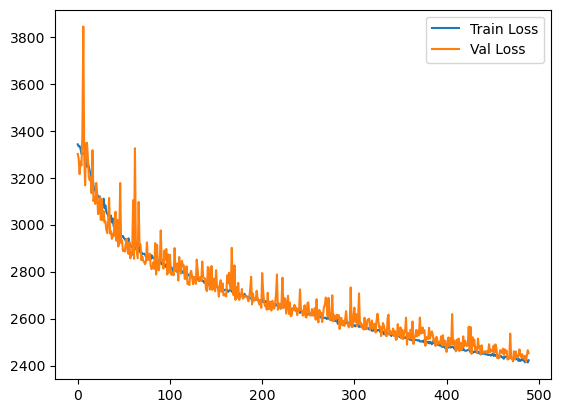

In [22]:
import matplotlib.pyplot as plt

plt.plot(losses['train'][10:], label='Train Loss')
plt.plot(losses['val'][10:], label='Val Loss')
plt.legend()
plt.show()

# Model Evaluation #

In [23]:
# Evaluate.

model.eval()
with torch.no_grad():
    test_loss = 0
    x_true = []
    y_true = []
    y_preds = []
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        x_true.extend(X_batch)
        y_true.extend(y_batch.view(-1, 1))
        y_preds.extend(y_pred)
        test_loss += criterion(y_pred, y_batch.view(-1, 1)).item()

# Save the model.
# torch.save(model.state_dict(), 'model.pth')
# print('Model saved.')

In [ ]:
import numpy as np

x_true = np.array(x_true)
economy = x_true[:, 0]
y_preds = torch.cat(y_preds, dim=0).numpy()
y_true = torch.cat(y_true, dim=0).numpy()
print(economy.shape, x_true.shape, y_preds.shape, y_true.shape)

(30016,) (30016, 15) (30016,) (30016,)


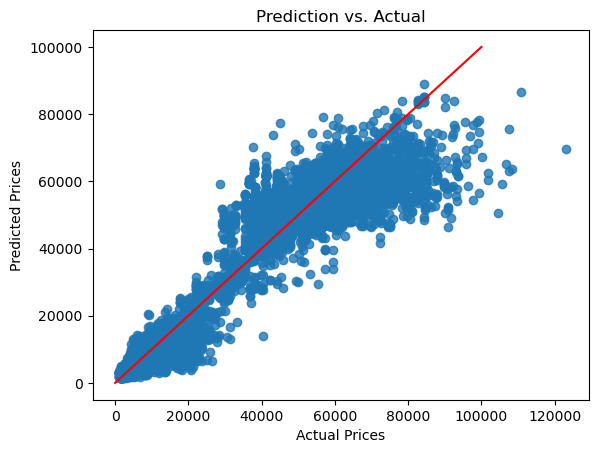

In [25]:
plt.scatter(y_true, y_preds, alpha=0.8)
plt.plot([0, 100000], [0, 100000], color='red')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Prediction vs. Actual")
plt.show()

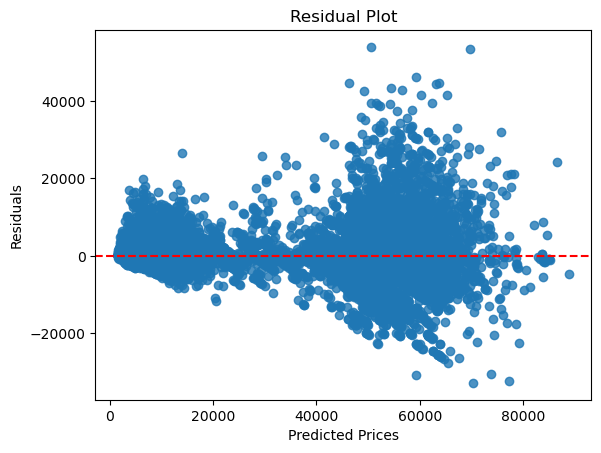

In [26]:
residuals = y_true - y_preds
plt.scatter(y_preds, residuals, alpha=0.8)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [27]:
from sklearn.metrics import r2_score, mean_absolute_error
from helper import evaluate, dic_print

dic_print(evaluate(y_true, y_preds))

R² Score: 0.96
MAE: 2473.49
Price Range: 121966.00
MAPE: 15.82
Average Price: 20859.41


In [ ]:
print("Economy")
dic_print(evaluate(y_true[economy == 1], y_preds[economy == 1]))

print("\nBusiness")
dic_print(evaluate(y_true[economy == 0], y_preds[economy == 0]))

Economy
R² Score: 0.73
MAE: 1187.04
Price Range: 39249.00
MAPE: 18.40
Average Price: 6567.29

Business
R² Score: 0.64
MAE: 5323.96
Price Range: 111071.00
MAPE: 10.10
Average Price: 52527.48


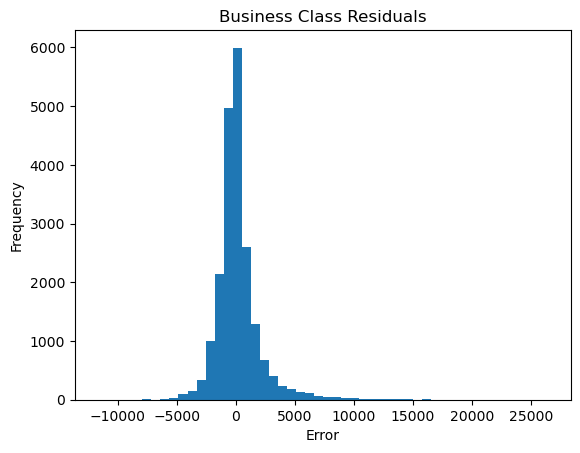

In [ ]:
business_residuals = y_true[economy == 1] - y_preds[economy == 1]
plt.hist(business_residuals, bins=50)
plt.title("Business Class Residuals")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

# Simple Regression #

In [ ]:
# simple linear regression.
from sklearn.linear_model import LinearRegression

# Read the dataset.
dtypes = {
    'airline': str,
    'source_city': str,
    'departure_time': str,
    'stops': str,
    'destination_city': str,
    'class': str,
    'duration': float,
    'days_left': int,
    'price': int
}
df = pd.read_csv('Clean_Dataset.csv', dtype=dtypes)

# Reformat the dataset.
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('source_city', axis=1, inplace=True)
df.drop('destination_city', axis=1, inplace=True)
df.drop('flight', axis=1, inplace=True)
df.drop('arrival_time', axis=1, inplace=True)
df.drop('departure_time', axis=1, inplace=True)

# One hot encoding.
df = pd.get_dummies(df, columns=['class'], drop_first=True)
df = pd.get_dummies(df, columns=['airline', 'stops'], drop_first=True)
df = df.astype({col: 'int' for col in df.select_dtypes('bool').columns})

# Reorder columns.
df.sort_values(['price', 'days_left'], inplace=True, ascending=[False, True])
columns = ['class_Economy'] + [col for col in df.columns if col != 'class_Economy']
df = df[columns]

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

dic_print(evaluate(y_test, y_pred))


R² Score: 0.91
MAE: 4600.63
Price Range: 121966.00
MAPE: 45.70
Average Price: 20882.64
